# Assess the influence of the temporal irreversiblity 

- using regional volume projections with random climate after year 2500 
    - creates suppl. figures ... 4_only_global_reversibility .... (+ variants)
    - creates RGI19_crazy_tipping_point_glaciers... 
         - e.g. potential mass-balance elevation feedback on single glaciers

In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# get the correct colors for the different scenarios
from analysis_func import color_scenario, label_scenario, provide_reg_full_name_dict, color_scenario_poster

palette = sns.color_palette(color_scenario.values())
scenarios = color_scenario.keys()

In [2]:
bc = 'bc_1980_2019' # 'bc_2000_2019' #x #
var = 'temp_21yr_avg'

pd_clim_all = pd.read_csv('../annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')

color_scenario_r = {}
color_scenario_r['initial state: stab_T15 after 500 years'] = color_scenario['stab_T15']
color_scenario_r['initial state: oversh_T30OS15 after 500 years'] = color_scenario['oversh_T30OS15']
color_scenario_r['initial state: zero after 500 years'] = 'black'

palette = sns.color_palette(color_scenario_r.values())



In [4]:
# this is the dataset with the same amount of common running glaciers by just using the for the first part 
df_scenario_usual = xr.open_dataset(f'common_running_of_random_runs_sum_all_provide_reg_oversh_stab_2000_2500_bc_1980_2019.nc').volume
#df_scenario_usual = xr.open_dataset(f'common_running_sum_all_provide_reg_oversh_stab_2000_2500_{bc}.nc').volume

_df_scenario = xr.open_dataset(f'common_running_random_climate_stab_T15_sum_all_provide_reg_oversh_stab__{bc}.nc')
df_scenario = _df_scenario.rolling(time=101, center=True, min_periods=101).mean()
df_scenario = df_scenario.dropna(dim='time')
# the same file of glacier projections for all figures:
#df_scenario = xr.open_dataset('filled_sum_all_provide_reg_oversh_stab_2000_2500.nc')

In [5]:
init_vol = (df_scenario_usual.sel(scenario='stab_T15').sel(time=2020).squeeze())
ratio_diff = (df_scenario.sum(dim='provide_region').volume - df_scenario.sum(dim='provide_region').volume.isel(time=-1))/init_vol.sum(dim='provide_region')
condi1 = np.abs(ratio_diff)<0.001

df_scenario_not_stabilised_glob = ratio_diff.where(condi1)
pd_scenario_not_stabilised_glob = df_scenario_not_stabilised_glob.to_dataframe().reset_index()
pd_scenario_not_stabilised_glob['provide_region'] = 'Globally'
pd_scenario_not_stabilised_glob = pd_scenario_not_stabilised_glob[['scenario', 'provide_region', 'time', 'volume']]
pd_scenario_not_stabilised_glob.index = pd_scenario_not_stabilised_glob.time
pd_scenario_not_stabilised_glob = pd_scenario_not_stabilised_glob.dropna()

#condi1 = df_scenario.volume/init_vol>=0.999
#condi2 = df_scenario.volume/init_vol<=1.001
ratio_diff = (df_scenario.volume - df_scenario.volume.isel(time=-1))/init_vol
condi1 = np.abs(ratio_diff)<0.001

df_scenario_not_stabilised = ratio_diff.where(condi1)
pd_scenario_not_stabilised = df_scenario_not_stabilised.to_dataframe().reset_index()
pd_scenario_not_stabilised = pd_scenario_not_stabilised.dropna()

pd_scenario_not_stabilised = pd.concat([pd_scenario_not_stabilised_glob, pd_scenario_not_stabilised])
pd_scenario_not_stabilised = pd_scenario_not_stabilised[['scenario', 'provide_region', 'time', 'volume']]
pd_scenario_not_stabilised = pd_scenario_not_stabilised.dropna()

pd_scenario_not_stabilised.index = pd_scenario_not_stabilised.time
pd_scenario_stabilised = pd_scenario_not_stabilised.groupby(['scenario', 'provide_region']).idxmin()[['time']].reset_index()
pd_scenario_stabilised = pd_scenario_stabilised.pivot(columns='provide_region', index='scenario')
pd_scenario_stabilised.columns = pd_scenario_not_stabilised.provide_region.unique()

In [6]:
pd_vol_scenario_rel = (100*df_scenario.volume/(df_scenario_usual.sel(scenario='stab_T15').sel(time=2020).squeeze())).to_dataframe('volume_rel_2020_%').reset_index()
df_scenario_glob = df_scenario.sum(dim='provide_region')
pd_vol_scenario_glob = (100*df_scenario_glob.volume/(df_scenario_usual.sum(dim='provide_region').sel(scenario='stab_T15').sel(time=2020).values)).to_dataframe('volume_rel_2020_%').reset_index()
pd_vol_scenario_rel['time_true'] = pd_vol_scenario_rel['time'] + 500
pd_vol_scenario_glob['time_true'] = pd_vol_scenario_glob['time'] + 500

pd_vol_scenario_rel_f = pd_vol_scenario_rel.loc[pd_vol_scenario_rel.time==15100.0]
pd_vol_scenario_rel_f.index = pd_vol_scenario_rel_f.provide_region
pd_vol_scenario_glob['provide_region'] = 'Globally'
pd_vol_scenario_glob_f = pd_vol_scenario_glob.loc[pd_vol_scenario_glob.time==15100.0]
pd_vol_scenario_glob_f.index = pd_vol_scenario_glob_f.provide_region
pd_vol_scenario_rel_f = pd.concat([pd_vol_scenario_glob_f, pd_vol_scenario_rel_f])
pd_vol_scenario_f_diff = pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: oversh_T30OS15 after 500 years']['volume_rel_2020_%'] - pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: stab_T15 after 500 years']['volume_rel_2020_%']
pd_vol_scenario_f_diff_zero = pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: zero after 500 years']['volume_rel_2020_%'] - pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: stab_T15 after 500 years']['volume_rel_2020_%']
pd_stats_stabilisation = pd.DataFrame([pd_vol_scenario_f_diff.round(1), pd_vol_scenario_f_diff_zero.round(1)])
pd_stats_stabilisation.index = ['Volume differences between initial states from overshoot +3.0°C->+1.5°C and stabilisation +1.5°C scenario (% relative to 2020)',
                               'Volume differences between initial states with zero volume and stabilisation +1.5°C scenario (% relative to 2020)']
pd_stats_stabilisation

provide_region                                      Globally  P01  P02  P03  \
Volume differences between initial states from ...      -1.6 -0.0 -0.4 -0.7   
Volume differences between initial states with ...      -5.0 -0.1 -1.1 -2.1   

provide_region                                      P04  P05  P06  P07  P08  \
Volume differences between initial states from ... -0.0 -0.1  0.0 -0.0  0.0   
Volume differences between initial states with ... -2.4 -2.0 -0.0 -0.0  0.0   

provide_region                                      P09  P10  P11  P12   P13  
Volume differences between initial states from ... -0.0  0.1 -0.0 -0.0  -4.7  
Volume differences between initial states with ... -0.0 -0.1 -2.9 -0.0 -13.8

In [7]:
pd_scenario_stabilised

Globally     P01      P02  \
scenario                                                                   
initial state: oversh_T30OS15 after 500 years    6336.0   714.0   9964.0   
initial state: stab_T15 after 500 years          1674.0    50.0   9120.0   
initial state: zero after 500 years             10674.0  1173.0  12108.0   

                                                  P03     P04      P05  \
scenario                                                                 
initial state: oversh_T30OS15 after 500 years  1961.0  1742.0   1887.0   
initial state: stab_T15 after 500 years        2460.0  1763.0   8605.0   
initial state: zero after 500 years            6671.0  2484.0  12788.0   

                                                  P06    P07    P08     P09  \
scenario                                                                      
initial state: oversh_T30OS15 after 500 years  1685.0  270.0   51.0  5300.0   
initial state: stab_T15 after 500 years        1229.0  104.0   60.0  5108.0   
initial state: zero after 500 years            2120.0  459.0  908.0  6086.0   

                                                 P10     P11    P12     P13  
scenario                                                                     
initial state: oversh_T30OS15 after 500 years   95.0   249.0  104.0  4128.0  
initial state: stab_T15 after 500 years        142.0   255.0   80.0  4590.0  
initial state: zero after 500 years            356.0  2006.0  296.0  8307.0

### Year when steady-state is reached:

In [9]:
condi1 = df_scenario.sum(dim='provide_region').volume/df_scenario.sum(dim='provide_region').volume.isel(time=-1)<=0.99
condi2 = df_scenario.sum(dim='provide_region').volume/df_scenario.sum(dim='provide_region').volume.isel(time=-1)>=1.01
df_scenario_not_stabilised_glob = df_scenario.sum(dim='provide_region').volume.where(condi1|condi2)
pd_scenario_not_stabilised_glob = df_scenario_not_stabilised_glob.to_dataframe().reset_index()
pd_scenario_not_stabilised_glob['provide_region'] = 'Globally'
pd_scenario_not_stabilised_glob.index = pd_scenario_not_stabilised_glob.time

condi1 = df_scenario.volume/df_scenario.volume.isel(time=-1)<=0.99
condi2 = df_scenario.volume/df_scenario.volume.isel(time=-1)>=1.01
df_scenario_not_stabilised = df_scenario.volume.where(condi1|condi2)
pd_scenario_not_stabilised = df_scenario_not_stabilised.to_dataframe().reset_index()
pd_scenario_not_stabilised.index = pd_scenario_not_stabilised.time
pd_scenario_not_stabilised = pd.concat([pd_scenario_not_stabilised_glob, pd_scenario_not_stabilised])
pd_scenario_not_stabilised.groupby(['scenario', 'provide_region'])[['volume']].idxmax()

volume
scenario                                      provide_region        
initial state: oversh_T30OS15 after 500 years Globally        1516.0
                                              P01              363.0
                                              P02             5737.0
                                              P03              611.0
                                              P04               50.0
                                              P05             1283.0
                                              P06              857.0
                                              P07              128.0
                                              P08                NaN
                                              P09             1757.0
                                              P10               52.0
                                              P11               81.0
                                              P12               50.0
                                              P13               50.0
initial state: stab_T15 after 500 years       Globally          50.0
                                              P01                NaN
                                              P02             4514.0
                                              P03               50.0
                                              P04               50.0
                                              P05              892.0
                                              P06              420.0
                                              P07               61.0
                                              P08                NaN
                                              P09             1458.0
                                              P10                NaN
                                              P11               50.0
                                              P12                NaN
                                              P13               50.0
initial state: zero after 500 years           Globally        7593.0
                                              P01              866.0
                                              P02             8534.0
                                              P03             4266.0
                                              P04             1933.0
                                              P05             9018.0
                                              P06             1125.0
                                              P07              286.0
                                              P08              301.0
                                              P09             2416.0
                                              P10              248.0
                                              P11              992.0
                                              P12              187.0
                                              P13             7232.0

## MERGED Plot:

In [20]:
df_scenario_usual = xr.open_dataset(f'common_running_of_random_runs_sum_all_provide_reg_oversh_stab_2000_2500_bc_1980_2019.nc').volume
#df_scenario_usual = xr.open_dataset(f'common_running_sum_all_provide_reg_oversh_stab_2000_2500_{bc}.nc').volume

_df_scenario = xr.open_dataset(f'common_running_random_climate_stab_T15_sum_all_provide_reg_oversh_stab__{bc}.nc').volume
#df_scenario = df_scenario.rolling(time=101, center=True, min_periods=101).mean()
#df_scenario = df_scenario.dropna(dim='time')
# the same file of glacier projections for all figures:
#df_scenario = xr.open_dataset('filled_sum_all_provide_reg_oversh_stab_2000_2500.nc')
# we actually decided to use the 
# global and glacier region climate changes:


In [21]:
_df_scenario_sel = _df_scenario.sel(scenario=['initial state: oversh_T30OS15 after 500 years',
                           'initial state: stab_T15 after 500 years'])
_df_scenario_sel.coords['time'] = _df_scenario_sel.coords['time']+2500

In [22]:
_df_scenario_sel.coords['scenario'] = ['oversh_T30OS15',
                           'stab_T15']
_df_scenario_sel.coords['gcm'] = ['GFDL-ESM2M']

In [23]:
df_all = xr.concat([df_scenario_usual.sel(scenario=_df_scenario_sel.scenario), _df_scenario_sel], dim='time')

(0.0, 2000.0)

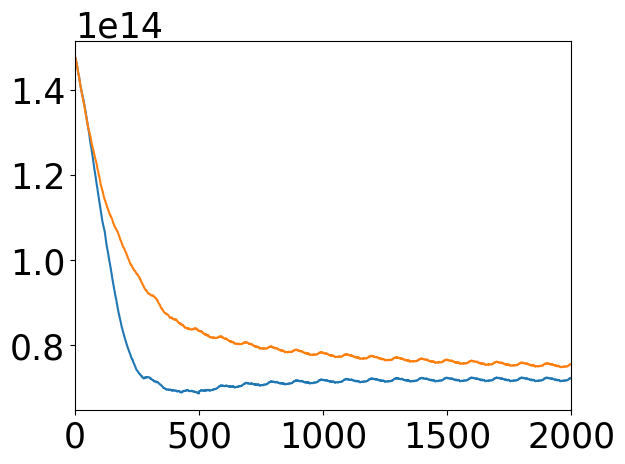

In [24]:
# just a quick check ...
plt.plot(df_all.sum(dim='provide_region').squeeze().T);
plt.xlim([0,2000])

In [25]:
roll_avg = 1

pd_vol_scenario_rel_all = (100*df_all/(df_all.sel(scenario='stab_T15').sel(time=2020).squeeze())).rolling(time=roll_avg, center=True).mean().dropna(dim='time',how='all').to_dataframe('volume_rel_2020_%').reset_index()

pd_vol_scenario_rel_glob_all = (100*df_all.sum(dim='provide_region').squeeze()/df_all.sum(dim='provide_region').sel(scenario='stab_T15').sel(time=2020).squeeze()).rolling(time=roll_avg, center=True).mean().dropna(dim='time',how='all').to_dataframe('volume_rel_2020_%').reset_index()
#pd_vol_scenario_glob = (100*df_scenario_glob.volume/(df_scenario_usual.sum(dim='provide_region').sel(scenario='stab_T15').sel(time=2020).values)).to_dataframe('volume_rel_2020_%').reset_index()


**Check how much % glacier loss occurs beyond 2500 for the stab 15 scenario**

In [43]:
_sel_2500 = pd_vol_scenario_rel_glob_all.loc[2500]
_sel_final = pd_vol_scenario_rel_glob_all.loc[17650]
_sel_2500.loc[_sel_2500.scenario=='stab_T15','volume_rel_2020_%'].values - _sel_final.loc[_sel_final.scenario=='stab_T15','volume_rel_2020_%'].values

array([5.8137703], dtype=float32)

In [26]:
pd_vol_scenario_rel_glob_all.loc[2499]

scenario                     oversh_T30OS15
time                                 4499.0
calendar_month                            1
gcm                              GFDL-ESM2M
bias_correction                bc_1980_2019
OGGM_version         OGGM_v161_gdirs_2023.3
volume_rel_2020_%                 51.135738
Name: 2499, dtype: object

In [27]:
pd_clim_all = pd.read_csv('../annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')


2252.0 16.058124542236328


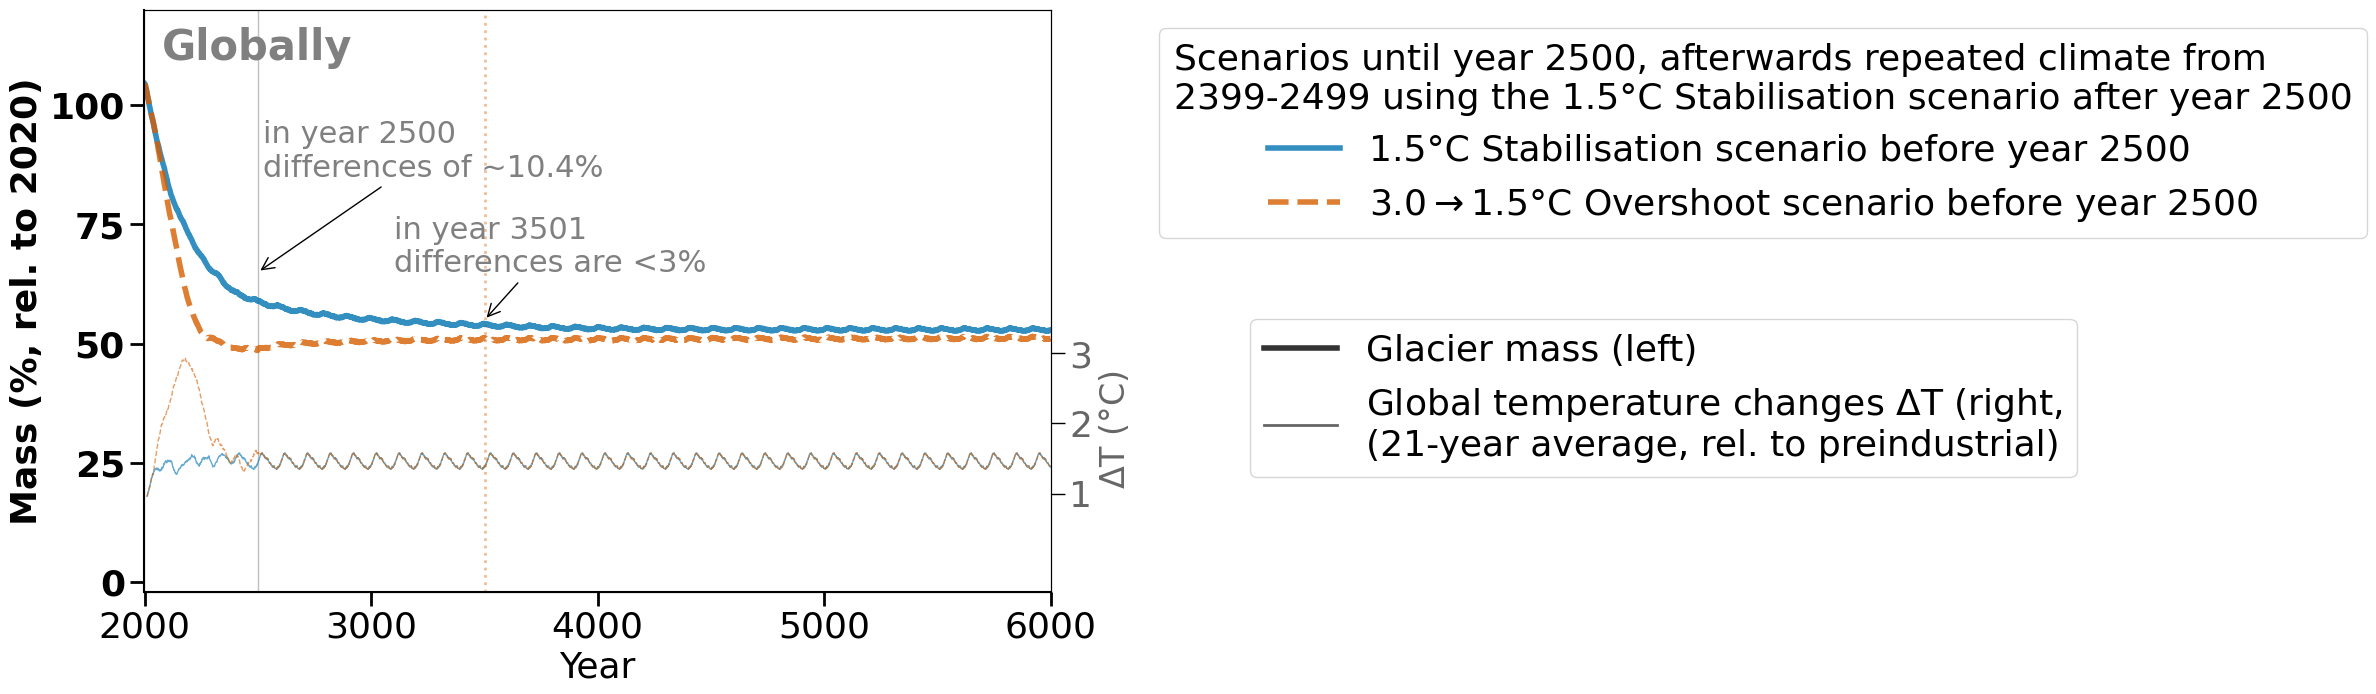

In [32]:
show_temp = True
if not show_temp:
    add = '_no_temp'
else:
    add = ''
    
if show_temp:
    alpha_temp = 1
    alpha_temp2 = 0.6
    width=1
    length=10
else:
    alpha_temp = 0
    alpha_temp2 = 0
    width=0
    length=10
    
show_global_temp = True
if show_global_temp:
    add = '_global_temp'


plt.rc('font', size=26)
portrait = True

plot_vlines = True


for a,color_scenarios in zip(['_all'],
                       [color_scenario_r]):
    #scenarios = color_scenarios.keys()
    scenarios = [ 'stab_T15', 'oversh_T30OS15']
    paletti = list(color_scenarios.values())[:-1]  
    if portrait:
        plt.figure(figsize=(42,28)) #, sharey=True, sharex=True)
        plt.subplot(4,4,1)
    else:
        plt.figure(figsize=(45,16)) #, sharey=True, sharex=True)
        plt.subplot(2,7,1)
    ax = plt.gca()
    #ax.set_title('Globally')
    plt.text(0.02,0.97, 'Globally',
             transform=ax.transAxes,ha='left',va='top',
             weight='bold',
             color='grey', fontsize=30)
    ax.set_ylabel('Mass (%, rel. to 2020)', weight='bold')
    sns.lineplot(data=pd_vol_scenario_rel_glob_all.loc[(pd_vol_scenario_rel_glob_all.bias_correction=='bc_1980_2019')&
                                                      (pd_vol_scenario_rel_glob_all.scenario!='oversh_T30OS15')],
                 x='time', y= 'volume_rel_2020_%', 
                 color=paletti[0],
                 label='stab',
                 ls='-',
                 #palette=paletti,
                 #hue_order=scenarios,
                 lw=4, legend=True, alpha=0.8,
                 ax = ax)
    sns.lineplot(data=pd_vol_scenario_rel_glob_all.loc[(pd_vol_scenario_rel_glob_all.bias_correction=='bc_1980_2019')&
                                                      (pd_vol_scenario_rel_glob_all.scenario=='oversh_T30OS15')],
                 x='time', y= 'volume_rel_2020_%', 
                 color=paletti[1],
                 label='oversh',
                 ls='--',
                 #palette=paletti,
                 #hue_order=scenarios,
                 lw=4, legend=True, alpha=0.8,
                 ax = ax)
    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_ylim([-2,120]);
    ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10)
    
    ax.set_xlabel('')
    #ax.set_xlim([2000,2500])
    #ax2.set_xlim([2000,2500])
    plt.axvline(2500, color='grey', zorder=-1, lw=1, alpha = 0.5)
    if plot_vlines:
        #for scenario in df_scenario.scenario.values:
        for scenario in ['initial state: oversh_T30OS15 after 500 years']:
            _p_sel = pd_vol_scenario_rel_glob_all#.loc[pd_vol_scenario_rel_glob_all.provide_region == Preg]
            _p_sel.index = _p_sel.time
            _p_sel = _p_sel.loc[_p_sel.scenario == 'stab_T15']['volume_rel_2020_%'] - _p_sel.loc[_p_sel.scenario == 'oversh_T30OS15']['volume_rel_2020_%']
            print(_p_sel.idxmax(), _p_sel.max())
            _p_sel = _p_sel.loc[2499:]
            yr = _p_sel.loc[_p_sel<3].index.min()
            
            plt.axvline(yr,ls=':', alpha = 0.4, lw=2, 
                       color=color_scenario_r[scenario], zorder=-1)
            if 'oversh' in scenario:
                plt.annotate(xy=(yr, 55),
                             xytext=(yr-400,65), text=f'in year {int(yr)}\ndifferences are <3%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
                _diff = _p_sel.loc[2499].round(1) # use 2499
                plt.annotate(xy=(2500, 65),
                             xytext=(2500+20,85), text=f'in year 2500\ndifferences of ~{_diff:0.1f}%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
    ax.set_xlabel('Year')

    ax2 = ax.twinx()  
    for scenario in scenarios:
        
        if show_global_temp:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()
            pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()

            var_g_to_ref = pd_temp_vals['temp']- pd_clim_scenario_g_ref + 0.63
            if 'oversh' in scenario:
                ls = '--'
            else:
                ls = '-'
            ax2.plot(pd_temp_vals.index,#pd_clim_scenario_g.year,
                var_g_to_ref, alpha = alpha_temp2, 
                ls = ls,
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
        else:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global_glacier']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()

            var_g_to_ref =pd_temp_vals['temp'] - temp_ref_g
            ax2.plot(pd_temp_vals.index,
                     var_g_to_ref,
                     alpha = alpha_temp2, 
                     ls = '-',
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    if show_global_temp:
        ax2.set_yticks(ticks=[1,2,3],
                       labels=[1,2,3], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                       labels=[0,1,2,3,4,5], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);

    #plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    #ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=width, length=length, grid_alpha =alpha_temp2)
    handles_2, labels_2_nice = ax2.get_legend_handles_labels()
    
    if show_global_temp:
        ax2.set_ylabel(r'$\Delta$T (°C)                         ', #                    '+'\n(vs. pre-industrial)         $_{global}$      ',
                                      alpha = alpha_temp2, fontsize=24)
    else:
        ax2.set_ylabel(r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)',
                                  alpha = alpha_temp2, fontsize=24)
    ax.set_xlim([1995,6000])
    ax2.set_xlim([1995,6000])

    
    han, lab = ax.get_legend_handles_labels()
    lab[0] = '1.5°C Stabilisation scenario before year 2500'
    lab[1] = r'3.0$\rightarrow$1.5°C Overshoot scenario before year 2500'
    #lab[2] = 'initial state with zero volume'
    ax.legend().remove()

    handles_2, labels_2 = ax2.get_legend_handles_labels()


    plt.tight_layout()
    leg = ax.legend(han, lab, loc = 'upper left',
                    bbox_to_anchor=(1.1,1), 
                    title='Scenarios until year 2500, afterwards repeated climate from\n2399-2499 using the 1.5°C Stabilisation scenario after year 2500')
    for l in leg.get_lines():
        l.set_linewidth(4)
        
        
    if show_temp:
        leg2 = ax.legend([han[0], handles_2[0]], ['Glacier mass (left)',
                                                 r'Global temperature changes $\Delta$T (right,' + '\n(21-year average, rel. to preindustrial)'],
                         loc='upper left', ncol=1, fontsize=26,
                        bbox_to_anchor=(1.2,0.5))
        leg2.get_lines()[0].set_linewidth(4)
        leg2.get_lines()[1].set_linewidth(2)
        for l in leg2.get_lines():
            l.set_color('black')
        ax.add_artist(leg)
    #if portrait:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.pdf')
    plt.savefig(f'figures/4_only_global_reversibility_V2_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation{add}.png',
                dpi=300)

    #else:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_random_climate_stabilisation.pdf')


## Same for individual regions (here Provide regions) - not used in manuscript


2252.0 16.058124542236328


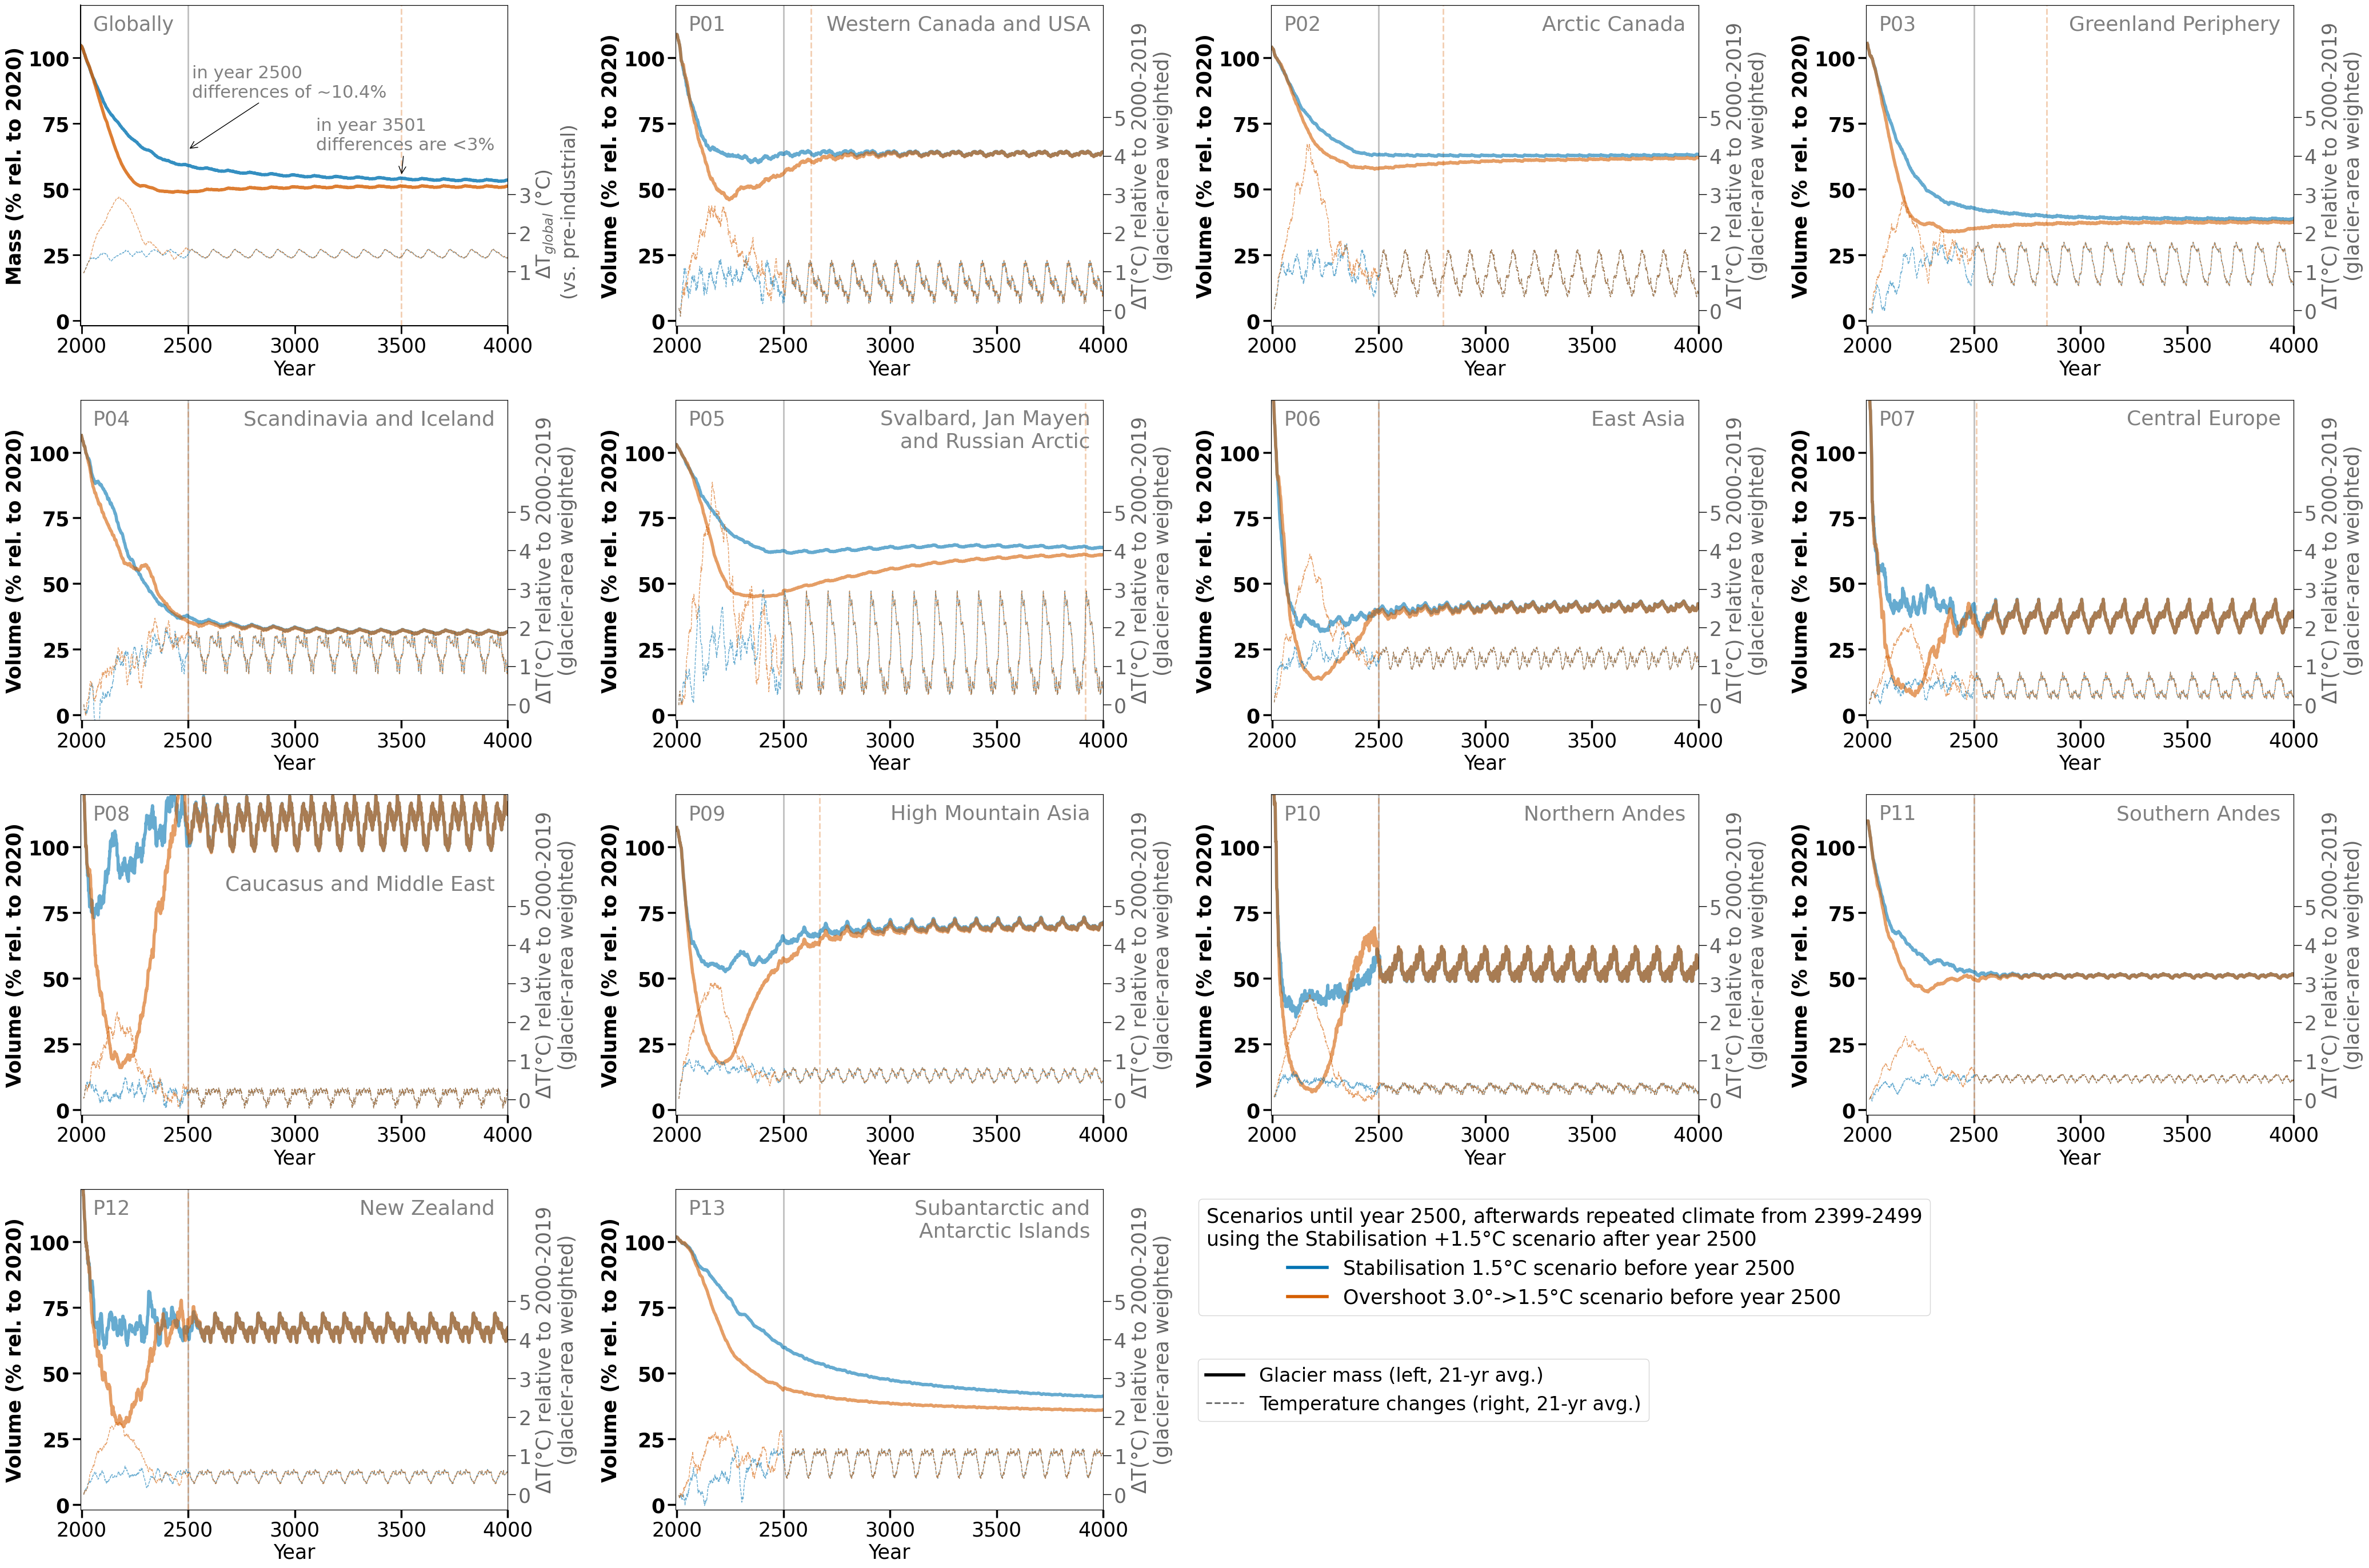

In [23]:
show_temp = True
if not show_temp:
    add = '_no_temp'
else:
    add = ''
    
if show_temp:
    alpha_temp = 1
    alpha_temp2 = 0.6
    width=1
    length=10
else:
    alpha_temp = 0
    alpha_temp2 = 0
    width=0
    length=10
    
show_global_temp = True
if show_global_temp:
    add = '_global_temp'


plt.rc('font', size=25)
portrait = True

plot_vlines = True


for a,color_scenarios in zip(['_all'],
                       [color_scenario_r]):
    #scenarios = color_scenarios.keys()
    scenarios = [ 'stab_T15', 'oversh_T30OS15']
    paletti = list(color_scenarios.values())[:-1]  
    if portrait:
        plt.figure(figsize=(42,28)) #, sharey=True, sharex=True)
        plt.subplot(4,4,1)
    else:
        plt.figure(figsize=(45,16)) #, sharey=True, sharex=True)
        plt.subplot(2,7,1)
    ax = plt.gca()
    #ax.set_title('Globally')
    plt.text(0.03,0.97, 'Globally',
             transform=ax.transAxes,ha='left',va='top',
             color='grey', fontsize=25)
    ax.set_ylabel('Mass (% rel. to 2020)', weight='bold')
    sns.lineplot(data=pd_vol_scenario_rel_glob_all.loc[pd_vol_scenario_rel_glob_all.bias_correction=='bc_1980_2019'],
                 hue='scenario', x='time', y= 'volume_rel_2020_%', 
                 palette=paletti,
                 hue_order=scenarios,lw=4, legend=False, alpha=0.8,
                 ax = ax)
    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_ylim([-2,120]);
    ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10)
    
    ax.set_xlabel('')
    #ax.set_xlim([2000,2500])
    #ax2.set_xlim([2000,2500])
    plt.axvline(2500, color='grey', zorder=-1, lw=2, alpha = 0.5)
    if plot_vlines:
        #for scenario in df_scenario.scenario.values:
        for scenario in ['initial state: oversh_T30OS15 after 500 years']:
            _p_sel = pd_vol_scenario_rel_glob_all#.loc[pd_vol_scenario_rel_glob_all.provide_region == Preg]
            _p_sel.index = _p_sel.time
            _p_sel = _p_sel.loc[_p_sel.scenario == 'stab_T15']['volume_rel_2020_%'] - _p_sel.loc[_p_sel.scenario == 'oversh_T30OS15']['volume_rel_2020_%']
            print(_p_sel.idxmax(), _p_sel.max())
            _p_sel = _p_sel.loc[2499:]
            yr = _p_sel.loc[_p_sel<3].index.min()
            
            plt.axvline(yr,ls='--', alpha = 0.3, lw=2, 
                       color=color_scenario_r[scenario], zorder=-1)
            if 'oversh' in scenario:
                plt.annotate(xy=(yr, 55),
                             xytext=(yr-400,65), text=f'in year {int(yr)}\ndifferences are <3%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
                _diff = _p_sel.loc[2499].round(1) # use 2499
                plt.annotate(xy=(2500, 65),
                             xytext=(2500+20,85), text=f'in year 2500\ndifferences of ~{_diff:0.1f}%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
    ax.set_xlabel('Year')

    ax2 = ax.twinx()  
    for scenario in scenarios:
        
        if show_global_temp:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()
            var_g_to_ref = pd_temp_vals['temp']- pd_clim_scenario_g_ref + 0.63

            ax2.plot(pd_temp_vals.index,#pd_clim_scenario_g.year,
                var_g_to_ref, alpha = alpha_temp2, 
                ls = '--',
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
        else:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global_glacier']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()

            var_g_to_ref =pd_temp_vals['temp'] - temp_ref_g
            ax2.plot(pd_temp_vals.index,
                     var_g_to_ref,
                     alpha = alpha_temp2, 
                     ls = '--',
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    if show_global_temp:
        ax2.set_yticks(ticks=[1,2,3],
                       labels=[1,2,3], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                       labels=[0,1,2,3,4,5], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);

    #plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    #ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=width, length=length, grid_alpha =alpha_temp2)
    handles_2, labels_2_nice = ax2.get_legend_handles_labels()
    
    if show_global_temp:
        ax2.set_ylabel(r'$\Delta$T$_{global}$ (°C)                    '+'\n(vs. pre-industrial)               ',
                                      alpha = alpha_temp2, fontsize=24)
    else:
        ax2.set_ylabel(r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)',
                                  alpha = alpha_temp2, fontsize=24)
    ax.set_xlim([1995,4000])
    ax2.set_xlim([1995,4000])

    
    for j, pi in enumerate(np.arange(1,14,1)):
        if pi<10:
            Preg = f'P0{pi}'
        else:
            Preg = f'P{pi}'
            
            
            
        if portrait:
            plt.subplot(4,4,j+2)
            x_j = np.arange(0,16,1)
            x2_j = x_j
            #x_j = np.arange(3,15,4)
            #x2_j = np.arange(2,15,4)
            year_xlabel_condi = j>10

        else:
            plt.subplot(2,7,j+2)
            x_j = [6]
            x2_j = [5,12]
            year_xlabel_condi = j>5
        ax = plt.gca()
        pd_vol_scenario_rel_reg = pd_vol_scenario_rel_all.loc[pd_vol_scenario_rel_all.provide_region==Preg]
        if pi ==13:
            legend=True
        else:
            legend=False
        sns.lineplot(data=pd_vol_scenario_rel_reg.loc[pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019'],
                     hue='scenario', x='time', y= 'volume_rel_2020_%', 
                     palette=paletti,
                 hue_order=scenarios,lw=4, legend=legend, alpha =0.6, 
                 ax = ax)

        #ax.set_title(f'{Preg}')
        plt.text(0.03,0.97, Preg,
                 transform=ax.transAxes,ha='left',va='top',
                 color='grey', fontsize=25)
        if Preg == 'P08':
            yy = 0.75
        else:
            yy= 0.97
        plt.text(0.97,yy, provide_reg_full_name_dict[Preg],
                 transform=ax.transAxes,ha='right',va='top',
                 color='grey', fontsize=26)
        ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        if j in x_j:
            ax.set_ylabel('Volume (% rel. to 2020)', weight='bold')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        else:
            plt.ylabel('')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], alpha=0, fontsize=1) #visible=False) 
            #plt.setp(ax.get_yticklabels(), visible=False)

        ax.set_ylim([-2,120]);
        ax.tick_params(axis='both', which='major', width=2.5, length=10)
        
        if year_xlabel_condi:
            ax.set_xlabel('Simulation years (after year 2500)')
        else:
            ax.set_xlabel('')

        #ax.set_xlim([2000,2500])
        #ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        #ax2.set_xlim([2000,2500])
        #ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)  
        plt.axvline(2500, color='grey', zorder=-1, lw=2, alpha = 0.5)

        if plot_vlines:
            _p_sel = pd_vol_scenario_rel_all.loc[pd_vol_scenario_rel_all.provide_region == Preg]
            _p_sel.index = _p_sel.time
            _p_sel = _p_sel.loc[_p_sel.scenario == 'stab_T15']['volume_rel_2020_%'] - _p_sel.loc[_p_sel.scenario == 'oversh_T30OS15']['volume_rel_2020_%']
            _p_sel = _p_sel.loc[2500:]
            _p_sel.loc[_p_sel<3].index.min()
            yr = _p_sel.loc[_p_sel<3].index.min()
            for scenario in ['initial state: oversh_T30OS15 after 500 years']: #df_scenario.scenario.values:
                plt.axvline(yr,ls='--', alpha = 0.3, lw=2, 
                            zorder=-1,
                       color=color_scenario_r[scenario])
        
        
        if pi ==13:
            han, lab = ax.get_legend_handles_labels()
            lab[0] = 'Stabilisation 1.5°C scenario before year 2500'
            lab[1] = 'Overshoot 3.0°->1.5°C scenario before year 2500'
            #lab[2] = 'initial state with zero volume'
            ax.legend().remove()
        ax.set_xlim([1995,4000])
        
        ax2 = ax.twinx()              
            
        for scenario in scenarios:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'provide_reg_{Preg}_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            _p_sel2 = pd_clim_all.loc[pd_clim_all.region==f'provide_reg_{Preg}_glacier']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()

            var_g_to_ref =pd_temp_vals['temp'] - temp_ref_g
            ax2.plot(pd_temp_vals.index,
                     var_g_to_ref,
                     alpha = alpha_temp2, 
                     ls = '--',
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])

        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=alpha_temp2)
        if j in x2_j:
            ax2.set_ylabel(r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)',
                          alpha = alpha_temp2)
            #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
        else:
            ax2.set_ylabel('')
            #ax2.set_yticks([])
            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
        
        ax2.set_ylim([-0.4,7.9]);

        ax2.tick_params(axis='both', which='major', width=width, length=length, grid_alpha =alpha_temp2)  
        handles_2, labels_2 = ax2.get_legend_handles_labels()
        ax2.set_xlim([1995,4000])
        ax.set_xlabel('Year')

    plt.tight_layout()
    leg = ax.legend(han, lab, loc = 'upper left',
                    bbox_to_anchor=(1.2,1),
                    title='Scenarios until year 2500, afterwards repeated climate from 2399-2499\nusing the Stabilisation +1.5°C scenario after year 2500')
    for l in leg.get_lines():
        l.set_linewidth(4)
        
        
    if show_temp:
        leg2 = ax.legend([han[0], handles_2[0]], ['Glacier mass (left, 21-yr avg.)',
                                                      'Temperature changes (right, 21-yr avg.)'],
                         loc='upper left', ncol=1, fontsize=24,
                        bbox_to_anchor=(1.2,0.5),)
        leg2.get_lines()[0].set_linewidth(4)
        leg2.get_lines()[1].set_linewidth(2)
        for l in leg2.get_lines():
            l.set_color('black')
        ax.add_artist(leg)
    #if portrait:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.pdf')
    plt.savefig(f'figures/4_provide_reg_reversibility_V2_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation{add}.png', dpi=300)

    #else:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_random_climate_stabilisation.pdf')


### Analysis for single glaciers - not used in manuscript

In [120]:
rgi_meta = pd.read_hdf('/home/www/oggm/rgi/rgi62_stats.h5')
rgi_meta = rgi_meta.loc[rgi_meta.Connect != 2]

In [14]:
preg = 13

In [40]:
Preg=f'P{preg:02}'

In [73]:
fpath = '/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/provide_reg/w5e5_gcm_merged_from_2000_bc_1980_2019'
ds_oversh_500yr = xr.open_dataset(f'{fpath}/{Preg}/provide_reg_{Preg}_oversh_T30OS15_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_1980_2019.nc')[['volume']]
ds_oversh_random = xr.open_dataset(f'{fpath}/{Preg}/random_climate_from2500_using2399_2499_provide_reg_{Preg}_initial_oversh_T30OS15_w5e5_gcm_merged_from_2000_bc_1980_2019.nc')
ds_oversh_random['time'] = ds_oversh_random.time.values + 2500
ds_T15_500yr = xr.open_dataset(f'{fpath}/{Preg}/provide_reg_{Preg}_stab_T15_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_1980_2019.nc')
ds_T15_random = xr.open_dataset(f'{fpath}/{Preg}/random_climate_from2500_using2399_2499_provide_reg_{Preg}_initial_stab_T15_w5e5_gcm_merged_from_2000_bc_1980_2019.nc')[['volume']]
ds_T15_random['time'] = ds_T15_random.time.values + 2500

ds_zero = xr.open_dataset(f'{fpath}/{Preg}/random_climate_from2500_using2399_2499_provide_reg_{Preg}_initial_zero_w5e5_gcm_merged_from_2000_bc_1980_2019.nc')
ds_zero['time'] = ds_zero.time.values + 2500

#ds_zero['time'] = ds_zero.time.values + 2500
ds_oversh_roll = ds_oversh_random.rolling(time=20, center=True).mean()
ds_T15_roll = ds_T15_random.rolling(time=20, center=True).mean()
ds_roll = ds_zero.rolling(time=20, center=True).mean()

# ds_oversh = xr.concat([ds_oversh_500yr, ds_oversh_random], dim = 'time')
ds_oversh_500yr_roll = ds_oversh_500yr.rolling(time=20, center=True).mean()
ds_T15_500yr_roll = ds_T15_500yr.rolling(time=20, center=True).mean()


In [202]:
fraction = ds_roll.volume.dropna(dim='time', how='all')/ds_T15_roll.volume.dropna(dim='time', how='all').values
fraction_f = fraction.sel(time=15051+2500-50)

fraction_oversh = ds_oversh_roll.volume.dropna(dim='time', how='all')/ds_T15_roll.volume.dropna(dim='time', how='all').values
fraction_oversh_f = fraction_oversh.sel(time=15051+2500-50)

In [270]:
#above 1km3 and a fraction of at least 0.9
fraction_oversh_f_sel = fraction_oversh_f.where((fraction_oversh_f<=0.9) & (ds_oversh_roll.volume.sel(time=15051+2500-50)>5e10)).dropna(dim='rgi_id')
rgis_strange = fraction_oversh_f_sel.rgi_id.values
rgi_meta_strange = rgi_meta.loc[rgis_strange]
rgi_meta_strange['Glacier_Type_Terminus'] = rgi_meta_strange.GlacierType +'_'+rgi_meta_strange.TerminusType
rgi_meta_strange
#rgi_meta_strange.groupby('Glacier_Type_Terminus').count()

GLIMSId   BgnDate   EndDate   CenLon   CenLat O1Region  \
RGIId                                                                           
RGI60-19.00893  G303675E63072S  19900218  -9999999 -56.3246 -63.0715       19   
RGI60-19.00119  G289014E69843S  20010219  -9999999 -70.9856 -69.8427       19   

               O2Region      Area  Zmin  Zmax  ...  TermType  Surging  \
RGIId                                          ...                      
RGI60-19.00893       21   432.818    10   390  ...         1        9   
RGI60-19.00119       19  2251.230    10  2530  ...         5        9   

                Linkages  Name  GlacierType        TerminusType  \
RGIId                                                             
RGI60-19.00893         9  None      Glacier  Marine-terminating   
RGI60-19.00119         9  None      Glacier   Shelf-terminating   

                     GlacierStatus  IsTidewater  IsNominal  \
RGIId                                                        
RGI60-19.00893  Glacier or ice cap         True      False   
RGI60-19.00119  Glacier or ice cap        False      False   

                     Glacier_Type_Terminus  
RGIId                                       
RGI60-19.00893  Glacier_Marine-terminating  
RGI60-19.00119   Glacier_Shelf-terminating  

[2 rows x 27 columns]

In [271]:
# the glacier with the largest differences 
fraction_oversh_f_sel_extreme = fraction_oversh_f.where((fraction_oversh_f<=0.6) & (ds_oversh_roll.volume.sel(time=15051+2500-50)>1e11)).dropna(dim='rgi_id') # at least 1km3 big in the new steady-state
fraction_oversh_f_sel_extreme.rgi_id

<xarray.DataArray 'rgi_id' (rgi_id: 1)>
array(['RGI60-19.00119'], dtype=object)
Coordinates:
    time             float64 1.75e+04
  * rgi_id           (rgi_id) object 'RGI60-19.00119'
    hydro_year       int64 15001
    hydro_month      int64 10
    calendar_year    int64 15001
    calendar_month   int64 1
    bias_correction  <U12 'bc_1980_2019'
    provide_region   <U3 'P13'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
Attributes:
    description:  RGI glacier identifier

In [272]:
fraction_f_sel = fraction_f.where((fraction_f<=0.9) & (ds_roll.volume.sel(time=15051-50)>5e10)).dropna(dim='rgi_id') # at least 1km3 big in the new steady-state
rgi_meta.loc[fraction_f_sel.rgi_id]

GLIMSId   BgnDate   EndDate    CenLon   CenLat  \
RGIId                                                                   
RGI60-19.01249  G287448E69562S  20010219  20020126  -72.5525 -69.5617   
RGI60-19.00417  G233765E73569S  -9999999  -9999999 -126.2350 -73.5690   
RGI60-19.00573  G304182E63271S  19900218  20000129  -55.8182 -63.2711   
RGI60-19.00167  G290544E70875S  19790299  -9999999  -69.4564 -70.8754   
RGI60-19.00113  G289727E69498S  19890220  20010219  -70.2728 -69.4976   
RGI60-19.00118  G289474E70612S  19790299  -9999999  -70.5258 -70.6118   
RGI60-19.00115  G289924E70013S  19790299  -9999999  -70.0759 -70.0127   
RGI60-19.00119  G289014E69843S  20010219  -9999999  -70.9856 -69.8427   
RGI60-19.00423  G260838E72287S  19721204  19730130  -99.1619 -72.2868   

               O1Region O2Region      Area  Zmin  Zmax  ...  Form  TermType  \
RGIId                                                   ...                   
RGI60-19.01249       19       19   688.885    10   530  ...     0         1   
RGI60-19.00417       19       16  2938.121    10  3010  ...     0         1   
RGI60-19.00573       19       21  1472.829    10   810  ...     0         1   
RGI60-19.00167       19       19   389.774    10  1150  ...     0         5   
RGI60-19.00113       19       19  1330.643    10  2810  ...     0         1   
RGI60-19.00118       19       19  1966.464    10  2490  ...     0         5   
RGI60-19.00115       19       19  2140.685    10  3070  ...     0         5   
RGI60-19.00119       19       19  2251.230    10  2530  ...     0         5   
RGI60-19.00423       19       18  5260.723    10   770  ...     0         5   

                Surging  Linkages                  Name  GlacierType  \
RGIId                                                                  
RGI60-19.01249        9         9  Rothschild Island IC      Glacier   
RGI60-19.00417        9         9     W Siple Island IC      Glacier   
RGI60-19.00573        9         9                  None      Glacier   
RGI60-19.00167        9         9      Alexander Island      Glacier   
RGI60-19.00113        9         9                  None      Glacier   
RGI60-19.00118        9         9      Alexander Island      Glacier   
RGI60-19.00115        9         9      Alexander Island      Glacier   
RGI60-19.00119        9         9                  None      Glacier   
RGI60-19.00423        9         9        Thurston I 001      Glacier   

                      TerminusType       GlacierStatus  IsTidewater  IsNominal  
RGIId                                                                           
RGI60-19.01249  Marine-terminating  Glacier or ice cap         True      False  
RGI60-19.00417  Marine-terminating  Glacier or ice cap         True      False  
RGI60-19.00573  Marine-terminating  Glacier or ice cap         True      False  
RGI60-19.00167   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00113  Marine-terminating  Glacier or ice cap         True      False  
RGI60-19.00118   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00115   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00119   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00423   Shelf-terminating  Glacier or ice cap        False      False  

[9 rows x 26 columns]

In [273]:
rgis_select = list(set(np.concatenate([fraction_oversh_f_sel.rgi_id.values.flatten(),fraction_f_sel.rgi_id.values.flatten()])))

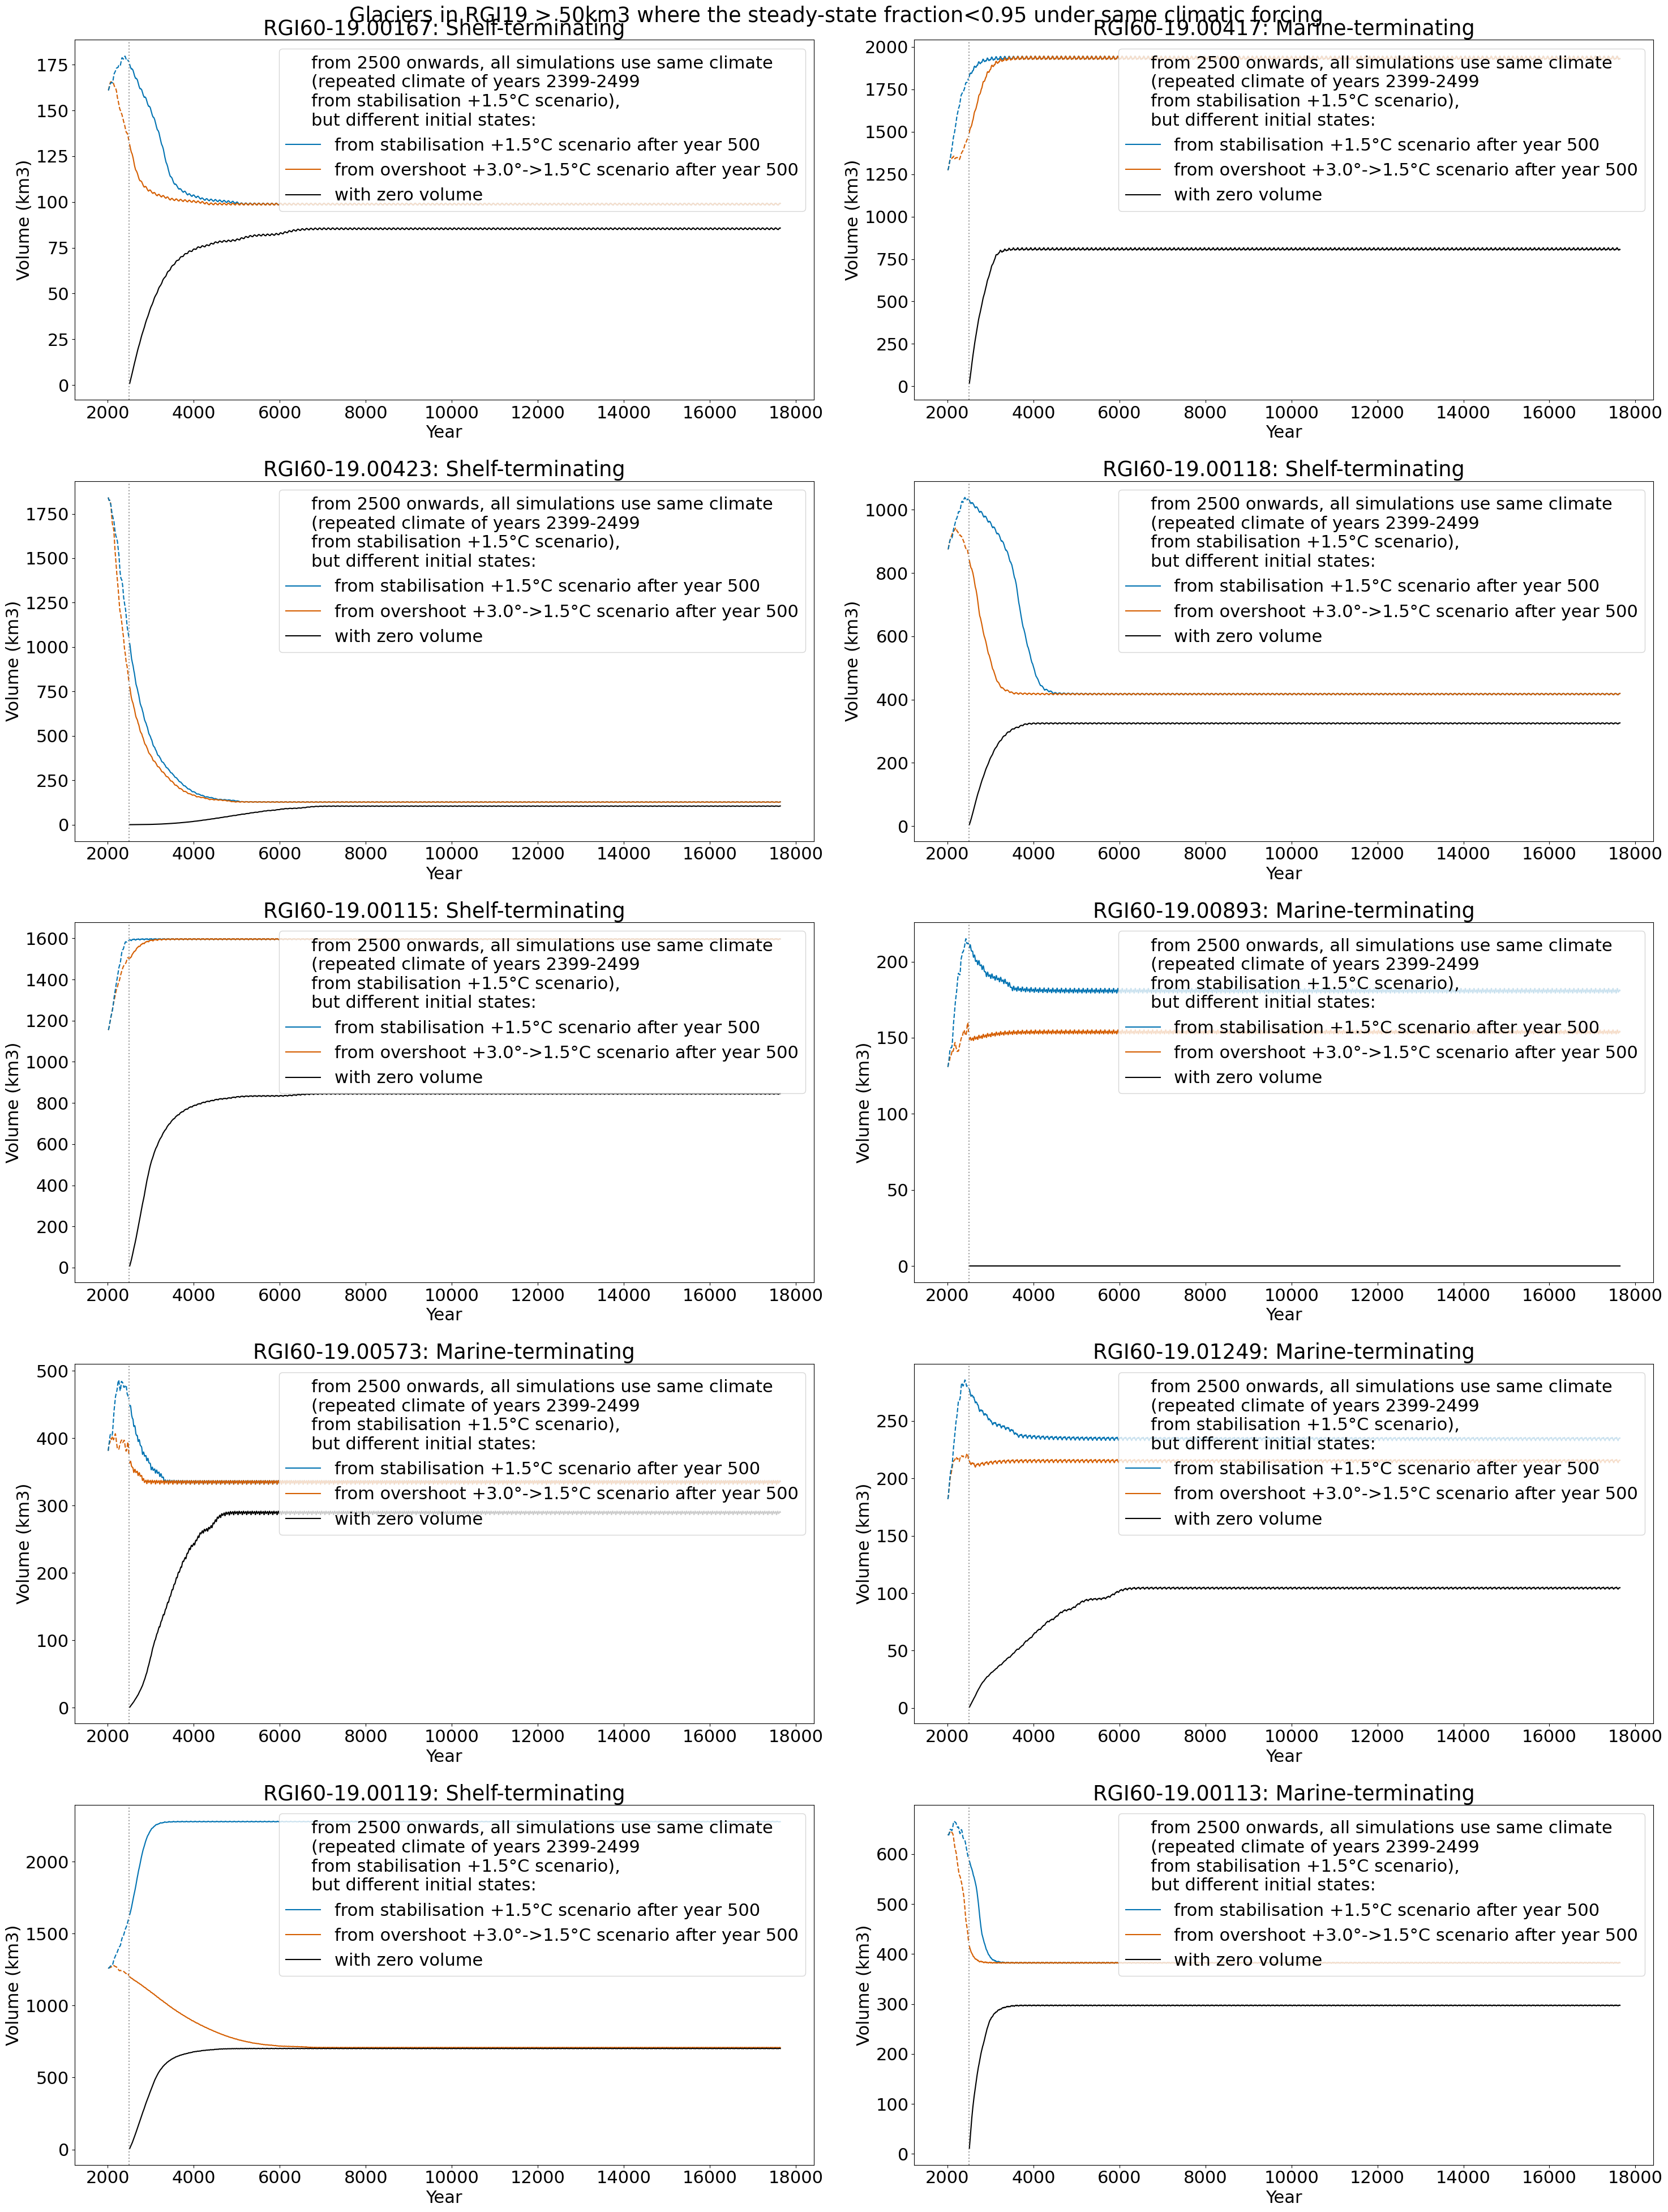

In [296]:
plt.rc('font', size=22)

fig,axs = plt.subplots(5,2,figsize=(30,40)) #, sharey=True)
axs =axs.flatten()
for j,rgi in enumerate(rgis_select):
    ax = axs[j]
    ax.plot(ds_oversh_500yr_roll.time, ds_oversh_500yr_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color=color_scenario['oversh_T30OS15'], ls='--')
    ax.plot(ds_T15_500yr_roll.time, ds_T15_500yr_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color=color_scenario['stab_T15'], ls='--')

    ax.plot(ds_T15_roll.time, ds_T15_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color=color_scenario['stab_T15'], 
             label='from stabilisation +1.5°C scenario after year 500')
    ax.plot(ds_oversh_roll.time, ds_oversh_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, 
             color=color_scenario['oversh_T30OS15'],
             label='from overshoot +3.0°->1.5°C scenario after year 500'
            )
    ax.plot(ds_roll.time, ds_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color='black',
            label='with zero volume')

    han, lab = ax.get_legend_handles_labels()
    ax.axvline(2500, color='grey', alpha = 0.8,ls=':')
    ax.legend(loc='upper right',
              title='from 2500 onwards, all simulations use same climate\n(repeated climate of years 2399-2499\nfrom stabilisation +1.5°C scenario),\nbut different initial states:') 
             # ,  loc='center right') #bbox_to_anchor=(1,0.9),
    ax.set_xlabel('Year')
    ax.set_ylabel('Volume (km3)');
    tip = rgi_meta.loc[rgi]['TerminusType']
    ax.set_title(f'{rgi}: {tip}')
    #ax.text(2900, 0, '--> , color='grey')
plt.suptitle('Glaciers in RGI19 > 50km3 where the steady-state fraction<0.95 under same climatic forcing')
plt.tight_layout()
plt.savefig('figures/4_RGI19_crazy_tipping_point_glaciers.png')

In [295]:
ds_T15_500yr_roll.dropna(dim='time', how='all').isel(time=-1).volume.sum()/1e9

<xarray.DataArray 'volume' ()>
array(29412.7182807)
Coordinates:
    time             float64 2.49e+03
    hydro_year       int64 2490
    hydro_month      int64 10
    calendar_year    int64 2490
    calendar_month   int64 1
    bias_correction  <U12 'bc_1980_2019'
    provide_region   <U3 'P13'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'

In [6]:
fraction_f_oversh_sel = fraction_oversh_f.where((fraction_oversh_f<=0.95) & (ds_oversh_roll.volume.sel(time=15051-50)>1e8)).dropna(dim='rgi_id') # at least 1km3 big in the new steady-state
fraction_f_oversh_sel.rgi_id

<xarray.DataArray 'rgi_id' (rgi_id: 4)>
array(['RGI60-01.03707', 'RGI60-01.04542', 'RGI60-01.01518', 'RGI60-01.24715'],
      dtype=object)
Coordinates:
    time             float64 1.5e+04
  * rgi_id           (rgi_id) object 'RGI60-01.03707' ... 'RGI60-01.24715'
    hydro_year       int64 15001
    hydro_month      int64 4
    calendar_year    int64 15001
    calendar_month   int64 1
    bias_correction  <U12 'bc_1980_2019'
    provide_region   <U3 'P01'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
Attributes:
    description:  RGI glacier identifier

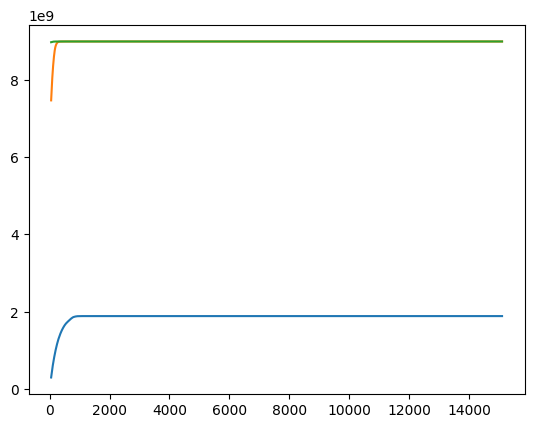

In [55]:
plt.plot(ds_roll.sel(rgi_id='RGI60-01.01245').volume.squeeze())
plt.plot(ds_oversh_roll.sel(rgi_id='RGI60-01.01245').volume.squeeze())

plt.plot(ds_T15_roll.sel(rgi_id='RGI60-01.01245').volume.squeeze())

## Old figure that got replaced by the above figures... 

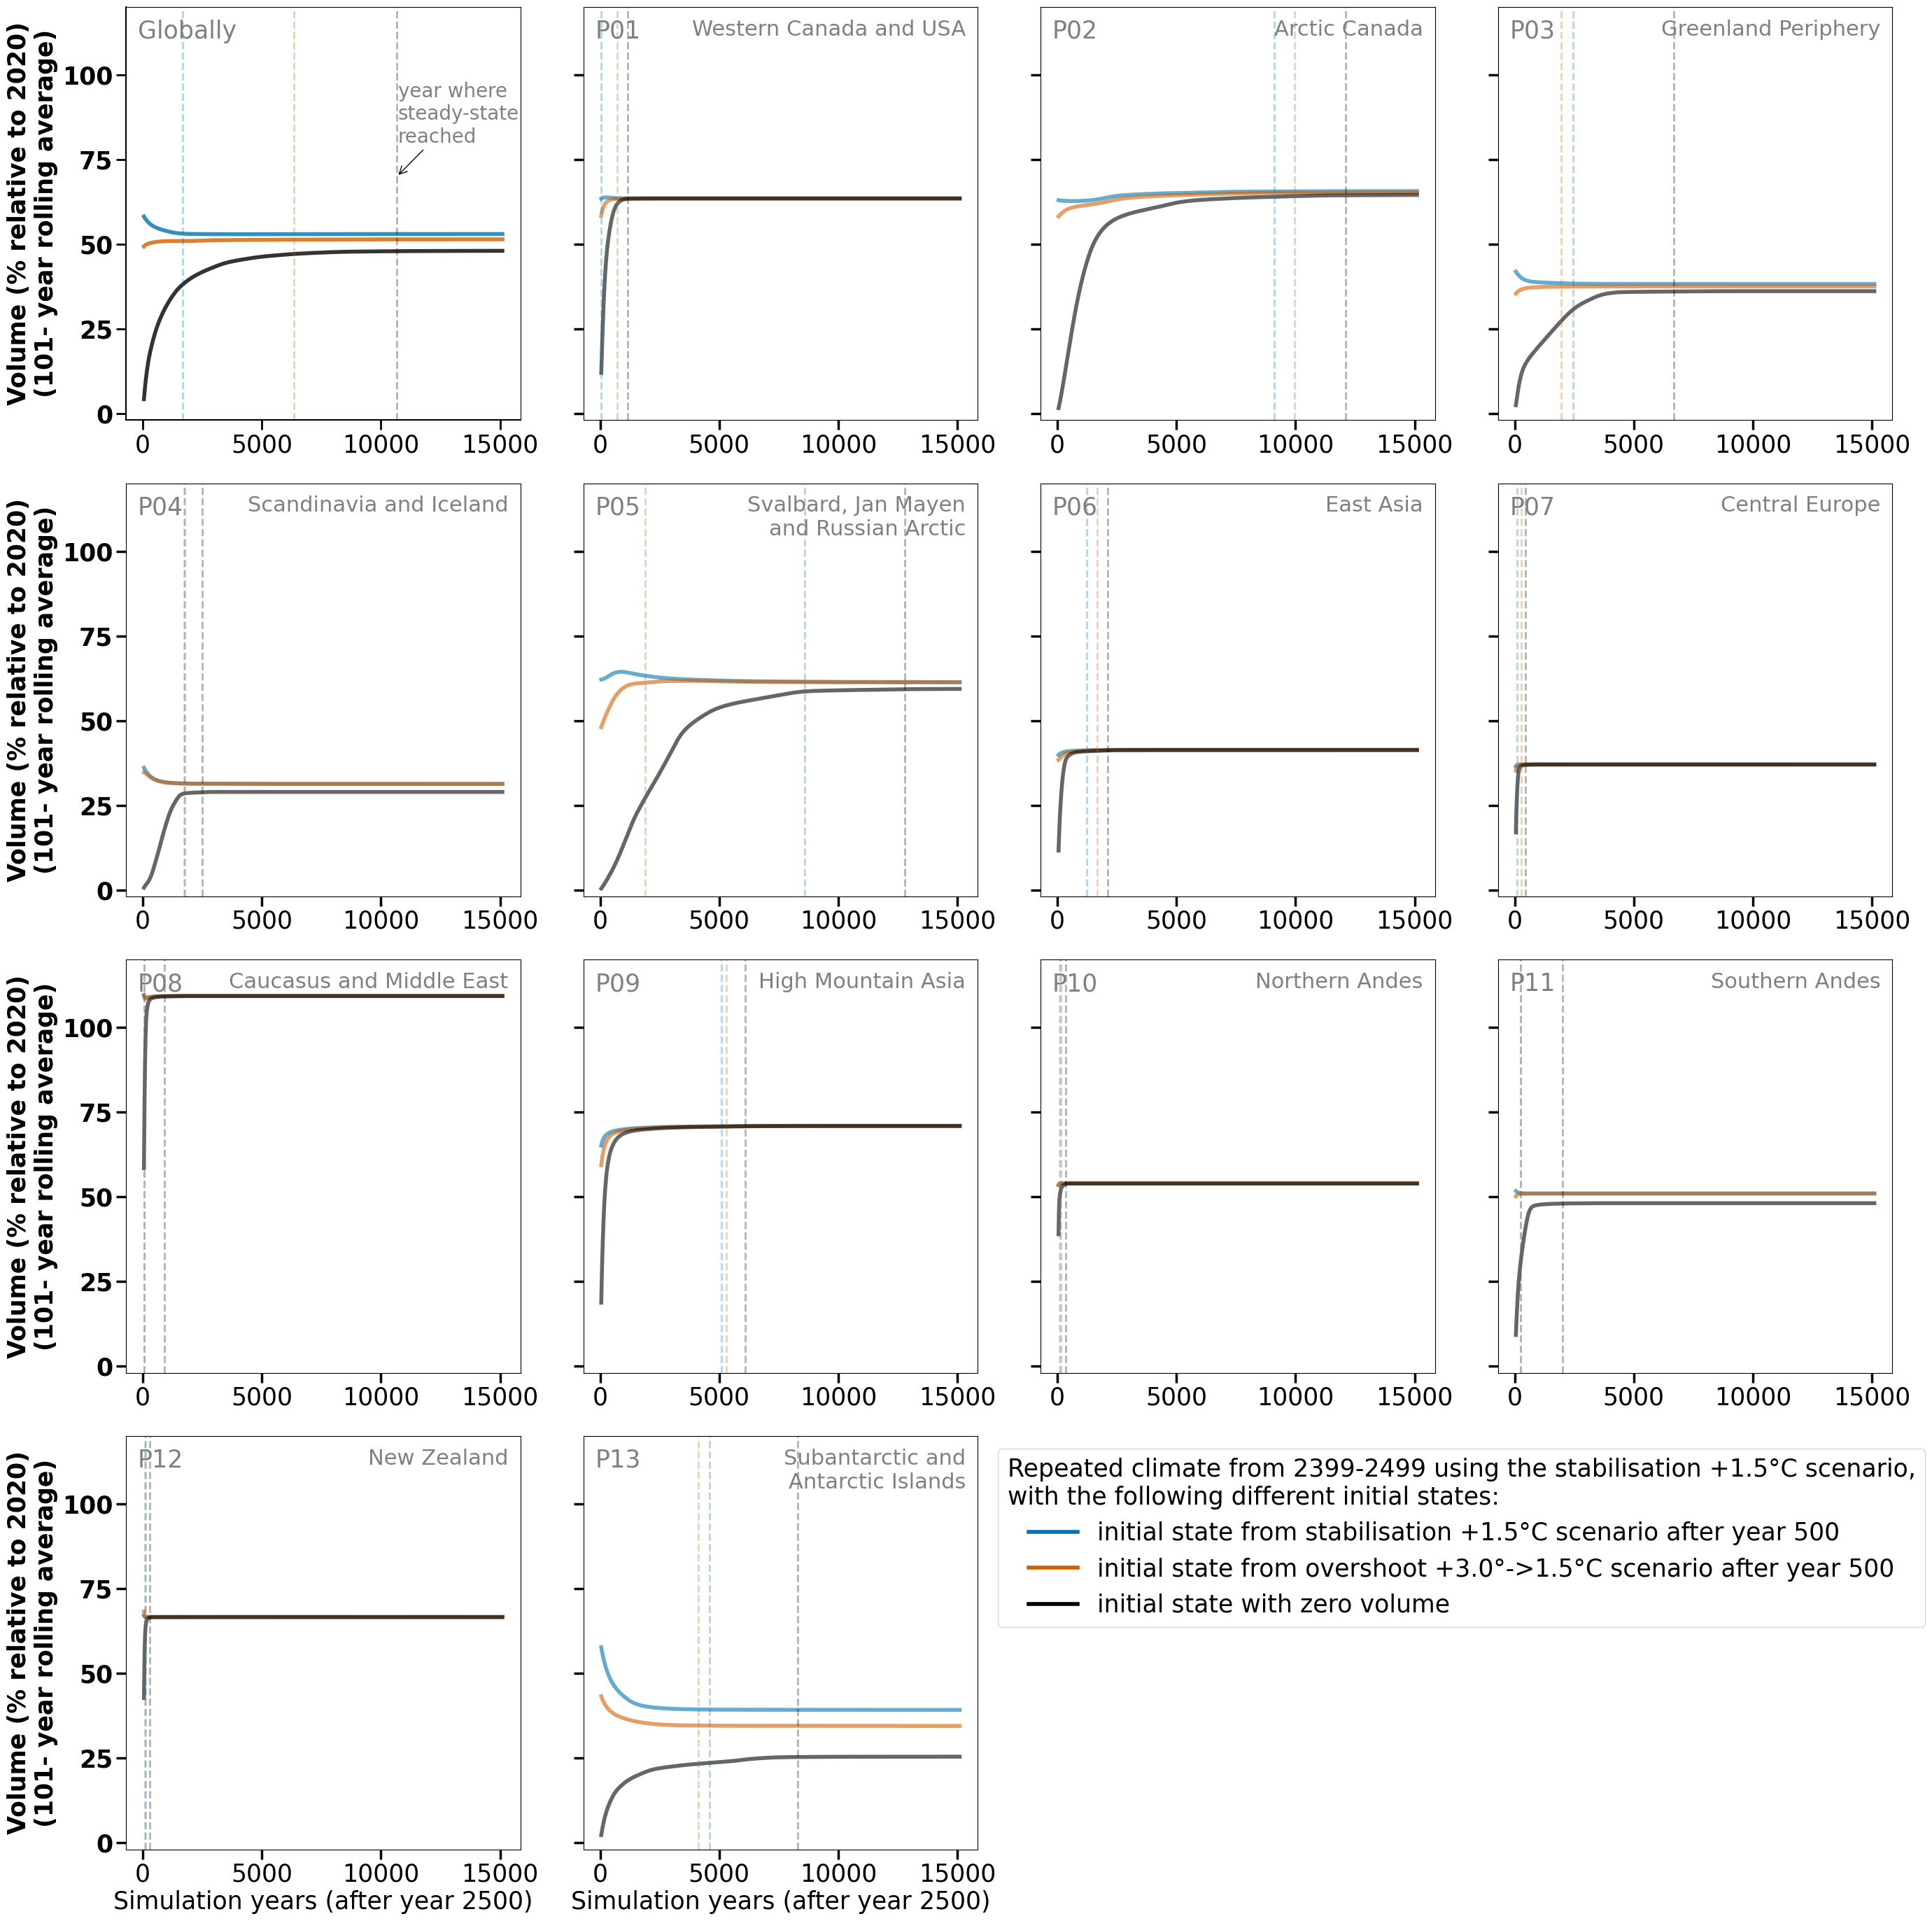

In [44]:

plt.rc('font', size=25)
portrait = True



for a,color_scenarios in zip(['_all'],
                       [color_scenario_r]):
    scenarios = color_scenarios.keys()
    paletti = list(color_scenarios.values())  
    if portrait:
        plt.figure(figsize=(28,28)) #, sharey=True, sharex=True)
        plt.subplot(4,4,1)
    else:
        plt.figure(figsize=(45,16)) #, sharey=True, sharex=True)
        plt.subplot(2,7,1)
    ax = plt.gca()
    #ax.set_title('Globally')
    plt.text(0.03,0.97, 'Globally',
             transform=ax.transAxes,ha='left',va='top',
             color='grey', fontsize=25)
    ax.set_ylabel('Volume (% relative to 2020)\n(101- year rolling average)', weight='bold')
    sns.lineplot(data=pd_vol_scenario_glob.loc[pd_vol_scenario_glob.bias_correction=='bc_1980_2019'],
                 hue='scenario', x='time', y= 'volume_rel_2020_%', 
                 palette=paletti,
                 hue_order=scenarios,lw=4, legend=False, alpha=0.8,
                 ax = ax)
    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_ylim([-2,120]);
    ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10)
    
    ax.set_xlabel('')
    #ax.set_xlim([2000,2500])
    #ax2.set_xlim([2000,2500])
    for scenario in df_scenario.scenario.values:
        plt.axvline(pd_scenario_stabilised['Globally'].loc[scenario],ls='--', alpha = 0.3, lw=2, 
                   color=color_scenario_r[scenario])
        if 'zero' in scenario:
            plt.annotate(xy=(pd_scenario_stabilised['Globally'].loc[scenario], 70),
                         xytext=(pd_scenario_stabilised['Globally'].loc[scenario]+50,80), text='year where\nsteady-state\nreached',
                         color='grey',arrowprops={'arrowstyle':'->'}, fontsize=20)

    for j, pi in enumerate(np.arange(1,14,1)):
        if pi<10:
            Preg = f'P0{pi}'
        else:
            Preg = f'P{pi}'
        if portrait:
            plt.subplot(4,4,j+2)
            x_j = np.arange(3,15,4)
            x2_j = np.arange(2,15,4)
            year_xlabel_condi = j>10

        else:
            plt.subplot(2,7,j+2)
            x_j = [6]
            x2_j = [5,12]
            year_xlabel_condi = j>5
        ax = plt.gca()
        pd_vol_scenario_rel_reg = pd_vol_scenario_rel.loc[pd_vol_scenario_rel.provide_region==Preg]
        if pi ==13:
            legend=True
        else:
            legend=False
        sns.lineplot(data=pd_vol_scenario_rel_reg.loc[pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019'],
                     hue='scenario', x='time', y= 'volume_rel_2020_%', 
                     palette=paletti,
                 hue_order=scenarios,lw=4, legend=legend, alpha =0.6, 
                 ax = ax)

        #ax.set_title(f'{Preg}')
        plt.text(0.03,0.97, Preg,
                 transform=ax.transAxes,ha='left',va='top',
                 color='grey', fontsize=25)
        plt.text(0.97,0.97, provide_reg_full_name_dict[Preg],
                 transform=ax.transAxes,ha='right',va='top',
                 color='grey', fontsize=22)
        ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        if j in x_j:
            ax.set_ylabel('Volume (% relative to 2020)\n(101- year rolling average)', weight='bold')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        else:
            plt.ylabel('')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], alpha=0, fontsize=1) #visible=False) 
            #plt.setp(ax.get_yticklabels(), visible=False)

        ax.set_ylim([-2,120]);
        ax.tick_params(axis='both', which='major', width=2.5, length=10)
        
        if year_xlabel_condi:
            ax.set_xlabel('Simulation years (after year 2500)')
        else:
            ax.set_xlabel('')

        #ax.set_xlim([2000,2500])
        #ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        #ax2.set_xlim([2000,2500])
        #ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)  
        
        for scenario in df_scenario.scenario.values:
            plt.axvline(pd_scenario_stabilised[Preg].loc[scenario],ls='--', alpha = 0.3, lw=2, 
                   color=color_scenario_r[scenario])
        
        
        if pi ==13:
            han, lab = ax.get_legend_handles_labels()
            lab[0] = 'initial state from stabilisation +1.5°C scenario after year 500'
            lab[1] = 'initial state from overshoot +3.0°->1.5°C scenario after year 500'
            lab[2] = 'initial state with zero volume'
            ax.legend().remove()

    plt.tight_layout()
    leg = ax.legend(han, lab, loc = 'upper left',
                    bbox_to_anchor=(1.02,1), title='Repeated climate from 2399-2499 using the stabilisation +1.5°C scenario,\nwith the following different initial states:')
    for l in leg.get_lines():
        l.set_linewidth(4)
    #plt.savefig('test_provide_reg.png', dpi=450) #, bbox_inches='tight')
    if portrait:
        plt.savefig(f'figures/4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.pdf')
        plt.savefig(f'figures/4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.png')

    else:
        plt.savefig(f'figures/4_provide_reg_volume_changes_overshoot{a}_{bc}_random_climate_stabilisation.pdf')